# Penerapan Model Jaringan Saraf Konvolusi untuk Klasifikasi Penyakit Daun Jagung Menggunakan Dataset Penyakit Daun Jagung

## Sumber Data:
### Corn or Maize Leaf Disease Dataset
[Kaggle - Corn or Maize Leaf Disease Dataset](https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset?resource=download)

## Identitas Peneliti:
### A11.2021.13654 | Luluk Ardianto

## Preprocessing

In [1]:
import numpy as np  # Mengimpor library NumPy dan memberinya alias np
import pandas as pd  # Mengimpor library pandas dan memberinya alias pd
import tensorflow as tf  # Mengimpor library TensorFlow dan memberinya alias tf
from tensorflow.keras import models, layers  # Mengimpor submodule models dan layers dari tensorflow.keras
import matplotlib.pyplot as plt  # Mengimpor library matplotlib untuk plotting dan memberinya alias plt
import keras  # Mengimpor library Keras

# Mengimpor modul untuk preprocessing dan aplikasi model dari Keras
from keras.preprocessing import image  # Mengimpor submodule image dari keras.preprocessing
from keras.applications.vgg19 import (
    VGG19,  # Mengimpor model VGG19 dari keras.applications.vgg19
    preprocess_input,  # Mengimpor fungsi untuk preprocessing input sebelum memasukkannya ke model VGG19
    decode_predictions  # Mengimpor fungsi untuk mendekode prediksi model VGG19
)

In [2]:
IMAGE_SIZE = (256, 256)  # Menetapkan ukuran gambar untuk preprocessing sebagai tuple (lebar, tinggi)
BATCH_SIZE = 32  # Menetapkan ukuran batch untuk pemrosesan data dalam pelatihan model

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",  # Direktori tempat dataset gambar berada
    shuffle=True,  # Mengacak urutan gambar saat memuat dataset
    image_size=IMAGE_SIZE,  # Ukuran gambar yang diubah ukurannya menjadi (256, 256)
    batch_size=BATCH_SIZE  # Ukuran batch gambar yang akan diproses dalam satu iterasi
)

Found 4188 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names  # Mendapatkan nama-nama kelas dari dataset
class_names  # Menampilkan nama-nama kelas

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [5]:
len(dataset)  # Mengembalikan jumlah batch dalam dataset

131

In [6]:
def get_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)  # Mendapatkan ukuran total dataset

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=8)  # Mengacak dataset jika shuffle=True, dengan ukuran buffer shuffle_size dan seed untuk reproduktifitas

    train_size = int(train_split * ds_size)  # Menghitung ukuran batch untuk data pelatihan
    val_size = int(val_split * ds_size)  # Menghitung ukuran batch untuk data validasi

    train_ds = ds.take(train_size)  # Mengambil batch data pelatihan dari dataset

    val_ds = ds.skip(train_size).take(val_size)  # Mengambil batch data validasi dari sisa dataset setelah data pelatihan
    test_ds = ds.skip(train_size).skip(val_size)  # Mengambil batch data pengujian dari sisa dataset setelah data pelatihan dan validasi
    
    class_counts = {}  # Dictionary untuk menyimpan jumlah kelas (belum digunakan)
    
    return train_ds, val_ds, test_ds  # Mengembalikan dataset pelatihan, validasi, dan pengujian

In [7]:
# Memanggil fungsi get_dataset untuk membagi dataset menjadi data pelatihan, validasi, dan pengujian
train_ds, val_ds, test_ds = get_dataset(dataset)

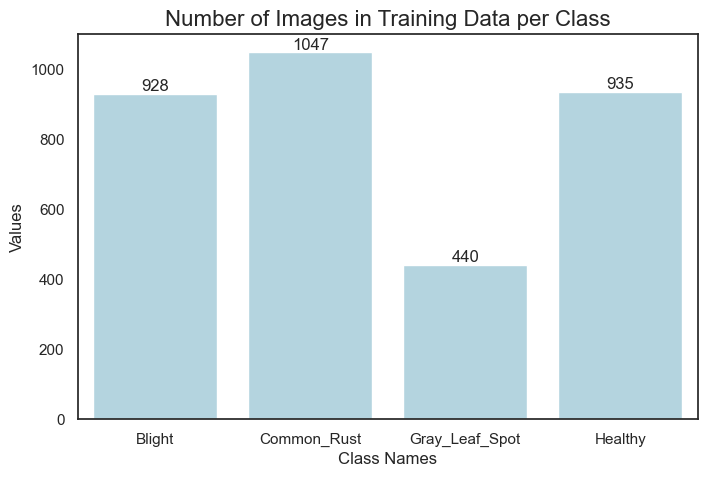

In [8]:
import seaborn as sns  # Mengimpor library Seaborn untuk visualisasi data
import matplotlib.pyplot as plt  # Mengimpor library Matplotlib untuk plotting

# Data
values = [928, 1047, 440, 935]  # Daftar nilai yang akan ditampilkan pada grafik batang
labels = class_names  # Label untuk setiap batang (dapat disesuaikan)

# Create a bar graph using Seaborn
sns.set(style="white")  # Mengatur gaya plot menjadi "white" tanpa garis kisi
plt.figure(figsize=(8, 5))  # Menetapkan ukuran figur menjadi 8x5 inci

# Choose a single color for all bars
bar_color = 'lightblue'  # Menentukan warna batang (dapat disesuaikan)

# Create the bar graph with a single color
sns.barplot(x=labels, y=values, color=bar_color)  # Membuat grafik batang dengan warna tunggal

# Add numeric values at the top of each bar
for i, v in enumerate(values):  # Mengulangi nilai dan indeks untuk menambahkan teks
    plt.text(i, v, str(v), ha='center', va='bottom')  # Menambahkan nilai numerik di atas setiap batang

# Add labels and a title
plt.xlabel('Class Names')  # Menambahkan label sumbu x
plt.ylabel('Values')  # Menambahkan label sumbu y
plt.title('Number of Images in Training Data per Class', fontsize=16)  # Menambahkan judul grafik dengan ukuran font 16

# Display the graph
plt.show()  # Menampilkan grafik

In [9]:
print("Length of Training Dataset is", len(train_ds))  # Mencetak panjang (jumlah batch) dari dataset pelatihan
print("\nLength of Validation Dataset is", len(val_ds))  # Mencetak panjang (jumlah batch) dari dataset validasi
print("\nLength of Testing Dataset is", len(test_ds))  # Mencetak panjang (jumlah batch) dari dataset pengujian

Length of Training Dataset is 104

Length of Validation Dataset is 13

Length of Testing Dataset is 14


In [10]:
 # Meng-cache dataset pelatihan, mengacak urutan dengan buffer_size 1000, dan memprefetch data untuk meningkatkan efisiensi
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Meng-cache dataset validasi, mengacak urutan dengan buffer_size 1000, dan memprefetch data
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Meng-cache dataset pengujian, mengacak urutan dengan buffer_size 1000, dan memprefetch data
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([  # Membuat model Sequential untuk preprocessing gambar
    tf.keras.layers.Resizing(255, 255),  # Menambahkan layer untuk mengubah ukuran gambar menjadi 255x255 piksel
    tf.keras.layers.Rescaling(1.0/255)  # Menambahkan layer untuk menormalisasi piksel gambar ke rentang [0, 1]
])

In [12]:
data_augmentation = tf.keras.Sequential([  # Membuat model Sequential untuk augmentasi data
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Menambahkan layer untuk membalik gambar secara horizontal dan vertikal secara acak
    tf.keras.layers.RandomRotation(0.2),  # Menambahkan layer untuk merotasi gambar secara acak hingga 20% (0.2 radian)
])

## Modeling

In [13]:
n_classes = 4  # Menetapkan jumlah kelas output model (karena ada 4 kelas jadi input 4)

input_shape = (BATCH_SIZE, 255, 255, 3)  # Menetapkan bentuk input gambar (batch size, tinggi, lebar, saluran warna)

model = models.Sequential([  # Membuat model Sequential untuk jaringan saraf konvolusi
    resize_and_rescale,  # Layer untuk resizing dan rescaling gambar
    data_augmentation,  # Layer untuk augmentasi data (flip dan rotation)
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # Layer konvolusi dengan 32 filter, ukuran kernel 3x3, dan fungsi aktivasi ReLU
    layers.MaxPooling2D((2, 2)),  # Layer pooling untuk mengurangi dimensi gambar dengan ukuran pool 2x2
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Layer konvolusi dengan 64 filter, ukuran kernel 3x3, dan fungsi aktivasi ReLU
    layers.MaxPooling2D((2, 2)),  # Layer pooling
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Layer konvolusi
    layers.MaxPooling2D((2, 2)),  # Layer pooling
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Layer konvolusi
    layers.MaxPooling2D((2, 2)),  # Layer pooling
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Layer konvolusi
    layers.MaxPooling2D((2, 2)),  # Layer pooling
    layers.Flatten(),  # Flatten layer untuk mengubah data dari format 2D ke 1D
    layers.Dense(64, activation='relu'),  # Fully connected layer dengan 64 neuron dan fungsi aktivasi ReLU
    layers.Dense(n_classes, activation='softmax'),  # Fully connected layer output dengan jumlah neuron sesuai kelas dan fungsi aktivasi softmax
])

model.build(input_shape=input_shape)  # Membangun model dengan bentuk input yang ditentukan

C:\Users\MP25B\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()  # Menampilkan ringkasan model, termasuk informasi tentang setiap layer, jumlah parameter, dan bentuk output

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 253, 253, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 126, 126, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 124, 124, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,956 (1.06 MB)

 Trainable params: 277,956 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    optimizer='adam',  # Menetapkan optimizer Adam untuk pelatihan model
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Menetapkan fungsi loss SparseCategoricalCrossentropy, tanpa logit
    metrics=['accuracy']  # Menetapkan metrik akurasi untuk evaluasi model
)

In [16]:
history = model.fit(
    train_ds,  # Dataset pelatihan yang akan digunakan untuk melatih model
    epochs=30,  # Jumlah epoch (putaran penuh melalui seluruh dataset) untuk pelatihan
    batch_size=BATCH_SIZE,  # Ukuran batch yang digunakan untuk pemrosesan data
    verbose=1,  # Menampilkan informasi pelatihan di konsol selama pelatihan (1 menunjukkan output progres)
    validation_data=val_ds  # Dataset validasi yang digunakan untuk memantau kinerja model selama pelatihan
)

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5871 - loss: 0.9431 - val_accuracy: 0.8486 - val_loss: 0.4500
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 92s 852ms/step - accuracy: 0.8266 - loss: 0.4446 - val_accuracy: 0.8606 - val_loss: 0.3660
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 729ms/step - accuracy: 0.8425 - loss: 0.3755 - val_accuracy: 0.8702 - val_loss: 0.4295
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 75s 717ms/step - accuracy: 0.8558 - loss: 0.3712 - val_accuracy: 0.8798 - val_loss: 0.3016
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 786ms/step - accuracy: 0.8572 - loss: 0.3218 - val_accuracy: 0.7380 - val_loss: 0.8889
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 78s 748ms/step - accuracy: 0.8081 - loss: 0.5215 - val_accuracy: 0.8702 - val_loss: 0.3160
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 75s 722ms/step - accuracy: 0.8657 - loss: 0.3220 - val_accuracy: 0.8822 - val_loss: 0.2773
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 701ms/step - accuracy: 0.8695 - loss: 0.2

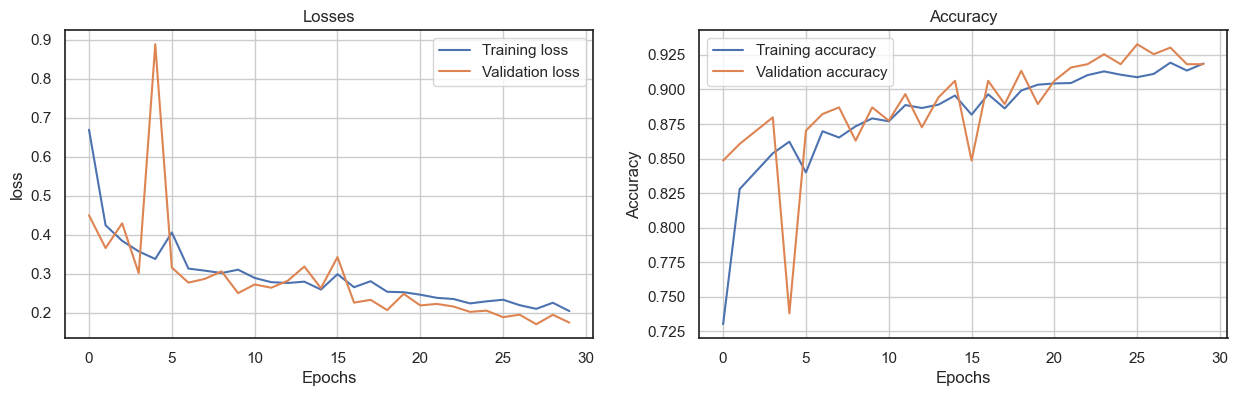

In [17]:
his_data = pd.DataFrame(history.history)  # Mengonversi riwayat pelatihan model menjadi DataFrame pandas untuk analisis lebih lanjut

plt.figure(figsize=(15, 4))  # Menetapkan ukuran figur plot menjadi 15x4 inci

# Membuat subplot pertama untuk menampilkan grafik loss
plt.subplot(1, 2, 1)  # Menetapkan subplot pada baris 1, kolom 2, posisi 1
plt.plot(his_data.loss, label="Training loss")  # Menggambar grafik loss pelatihan
plt.plot(his_data.val_loss, label="Validation loss")  # Menggambar grafik loss validasi
plt.xlabel("Epochs")  # Menetapkan label sumbu x sebagai "Epochs"
plt.ylabel("loss")  # Menetapkan label sumbu y sebagai "loss"
plt.title("Losses")  # Menetapkan judul subplot sebagai "Losses"
plt.grid()  # Menampilkan grid pada plot
plt.legend()  # Menampilkan legenda pada plot

# Membuat subplot kedua untuk menampilkan grafik akurasi
plt.subplot(1, 2, 2)  # Menetapkan subplot pada baris 1, kolom 2, posisi 2
plt.plot(his_data.accuracy, label="Training accuracy")  # Menggambar grafik akurasi pelatihan
plt.plot(his_data.val_accuracy, label="Validation accuracy")  # Menggambar grafik akurasi validasi
plt.xlabel("Epochs")  # Menetapkan label sumbu x sebagai "Epochs"
plt.ylabel("Accuracy")  # Menetapkan label sumbu y sebagai "Accuracy"
plt.title("Accuracy")  # Menetapkan judul subplot sebagai "Accuracy"
plt.grid()  # Menampilkan grid pada plot
plt.legend()  # Menampilkan legenda pada plot

In [18]:
scores = model.evaluate(test_ds)  # Mengevaluasi model menggunakan dataset pengujian dan menyimpan skor evaluasi (loss dan metrik) dalam variabel scores

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - accuracy: 0.9020 - loss: 0.2735


In [19]:
# After training, make predictions on the test dataset
predictions = model.predict(test_ds)  # Menggunakan model untuk membuat prediksi pada dataset pengujian

# Get the actual class labels from the test dataset
actual_labels = []  # Daftar untuk menyimpan label kelas aktual
for x, y in test_ds:  # Iterasi melalui dataset pengujian
    actual_labels.extend(y.numpy())  # Menambahkan label kelas aktual dari batch ke daftar

# Convert the predicted probabilities to class labels
predicted_labels = [np.argmax(p) for p in predictions]  # Mengonversi probabilitas yang diprediksi menjadi label kelas dengan memilih indeks dengan probabilitas tertinggi

# Calculate accuracy per class
from sklearn.metrics import accuracy_score, classification_report  # Mengimpor fungsi untuk menghitung akurasi dan laporan klasifikasi
accuracy = accuracy_score(actual_labels, predicted_labels)  # Menghitung akurasi keseluruhan
report = classification_report(actual_labels, predicted_labels, target_names=["Blight", "Common_Rust", "Gray_Leaf_Spot", "Healthy"])  # Menghasilkan laporan klasifikasi dengan akurasi per kelas

print("Overall Accuracy:", accuracy)  # Mencetak akurasi keseluruhan
print("Accuracy per Class:")  # Mencetak header untuk akurasi per kelas
print(report)  # Mencetak laporan klasifikasi

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step
Overall Accuracy: 0.2767857142857143
Accuracy per Class:
                precision    recall  f1-score   support

        Blight       0.32      0.33      0.32       128
   Common_Rust       0.31      0.30      0.31       151
Gray_Leaf_Spot       0.10      0.11      0.10        47
       Healthy       0.26      0.26      0.26       122

      accuracy                           0.28       448
     macro avg       0.25      0.25      0.25       448
  weighted avg       0.28      0.28      0.28       448



In [20]:
from sklearn.metrics import accuracy_score  # Mengimpor fungsi untuk menghitung akurasi dari sklearn

# After training, make predictions on the test dataset
predictions = model.predict(test_ds)  # Menggunakan model untuk membuat prediksi pada dataset pengujian

# Get the actual class labels from the test dataset
actual_labels = []  # Daftar untuk menyimpan label kelas aktual
for x, y in test_ds:  # Iterasi melalui dataset pengujian
    actual_labels.extend(y.numpy())  # Menambahkan label kelas aktual dari batch ke daftar

# Convert the predicted probabilities to class labels
predicted_labels = [np.argmax(p) for p in predictions]  # Mengonversi probabilitas yang diprediksi menjadi label kelas dengan memilih indeks dengan probabilitas tertinggi

# Calculate accuracy per class
num_classes = 4  # Menetapkan jumlah kelas (harus disesuaikan dengan jumlah kelas yang sebenarnya)
accuracy_per_class = []  # Daftar untuk menyimpan akurasi per kelas

for class_idx in range(num_classes):  # Iterasi melalui setiap kelas
    # Mendapatkan indeks dari label aktual untuk kelas saat ini
    class_indices = [i for i, label in enumerate(actual_labels) if label == class_idx]
    # Mendapatkan label aktual dan prediksi untuk kelas saat ini
    class_true_labels = [actual_labels[i] for i in class_indices]
    class_predicted_labels = [predicted_labels[i] for i in class_indices]
    # Menghitung akurasi untuk kelas saat ini
    class_accuracy = accuracy_score(class_true_labels, class_predicted_labels)
    accuracy_per_class.append(class_accuracy)  # Menambahkan akurasi kelas ke daftar

# Print accuracy per class
class_names = ["Blight", "Common_Rust", "Gray_Leaf_Spot", "Healthy"]  # Daftar nama kelas
for class_name, accuracy in zip(class_names, accuracy_per_class):  # Iterasi melalui nama kelas dan akurasi
    print(f"Accuracy for class '{class_name}': {accuracy:.2%}")  # Mencetak akurasi untuk setiap kelas dalam format persentase

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step
Accuracy for class 'Blight': 27.34%
Accuracy for class 'Common_Rust': 33.11%
Accuracy for class 'Gray_Leaf_Spot': 6.38%
Accuracy for class 'Healthy': 36.89%


In [21]:
# Assuming you have already created your train_ds, val_ds, and test_ds datasets
model.predict(test_ds)  # Menggunakan model untuk membuat prediksi pada dataset pengujian (test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step


array([[9.2451447e-01, 1.0826649e-03, 7.4402817e-02, 5.9143128e-11],
       [9.9998200e-01, 1.9369411e-06, 1.6070619e-05, 3.5830094e-10],
       [1.8999422e-01, 5.4722009e-03, 8.0453336e-01, 2.1848976e-07],
       ...,
       [8.9963324e-02, 4.1654846e-03, 9.0587115e-01, 5.2932620e-08],
       [1.0246354e-03, 9.9897504e-01, 3.3138403e-07, 2.0477975e-12],
       [3.2797153e-04, 9.9967206e-01, 6.9244055e-09, 2.1104657e-18]],
      dtype=float32)

First Image to Predict :

Actual label: Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step

Predicted label Blight


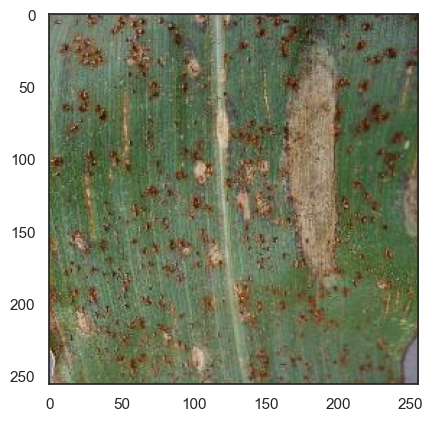

In [22]:
import numpy as np  # Mengimpor library NumPy untuk operasi array

# Mengambil satu batch gambar dan label dari dataset pengujian
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')  # Mengonversi gambar pertama dalam batch menjadi array NumPy dengan tipe data uint8
    first_label = labels_batch[0].numpy()  # Mengonversi label pertama dalam batch menjadi array NumPy
    print("First Image to Predict :")  # Mencetak pesan untuk menunjukkan gambar pertama yang akan diprediksi
    plt.imshow(first_image)  # Menampilkan gambar pertama
    print("\nActual label:", class_names[first_label])  # Mencetak label aktual gambar pertama menggunakan nama kelas

    batch_prediction = model.predict(images_batch)  # Menggunakan model untuk membuat prediksi pada batch gambar
    print("\nPredicted label", class_names[np.argmax(batch_prediction[0])])  # Mencetak label yang diprediksi untuk gambar pertama, menggunakan kelas dengan probabilitas tertinggi